# ***Energy Supply and Demand Optimisation: Mathematical Modelling Using __Gurobi Python__***


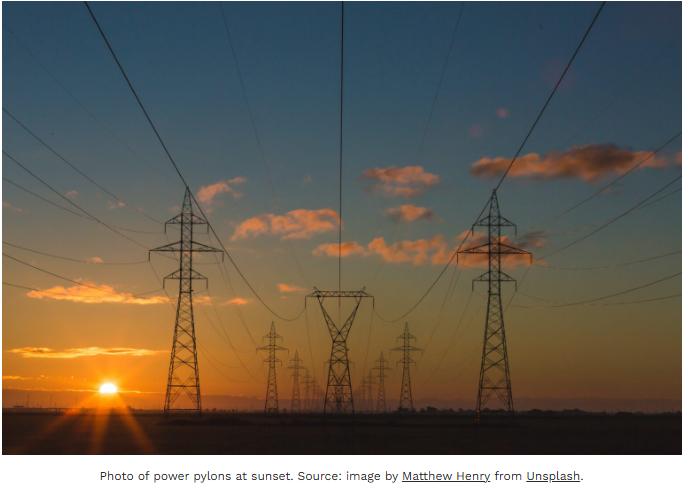

Let us envision a hypothetical situation where we are responsible for formulating the yearly budget for energy production and storage in a fictitious country. In this country, there are only four energy sources, namely solar, wind, natural gas, and nuclear.

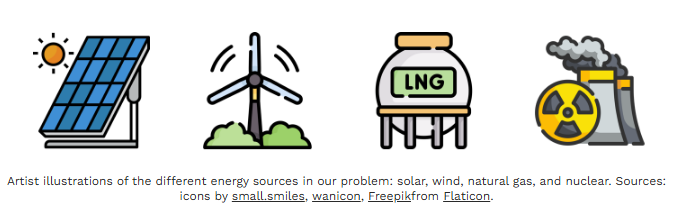





We have access to data detailing their monthly production and storage capacities, and also insights into the associated production and storage costs. Additionally, we assume to have the understanding of the energy demand throughout the year. The key question is: how can we optimise the monthly production and storage quantities for each energy source to minimise the total annual cost?

## ***2. Mathematical formulation:***

### 2.1. Parameters:

The mathematical notations used in our model; we denote e ∈ E as the type of energy source in the set of all energy sources E (solar, wind, natural gas, and nuclear), and t ∈ T as the month in the set of all the months T (January, February, March, and so on).

Now, we introduce the following parameters given for our problem:

- Dₜ is the total projected energy demand for month t.
- Pₜₑ is the production upper limit of energy source e in month t.
- Sₜₑ is the storage upper limit of energy source e in month t.
- Aₑ is the production cost of energy source e .
- Bₑ is the storage cost of energy source e.

The variables of our model are defined as follow:

- xₜₑ is the amount of energy source e produced in month t.
- yₜₑ is the amount of energy source e remained in month t, which is also the amount that will be stored during that month.
- zₜₑ is the amount of energy source e used in month t to satisfy the energy demand for that month.

### 2.2. Objective function
Now, we will define our objective function. Our aim is to minimise the total cost for the entire year. This can be expressed in mathematical terms as follows:

$$
\min \sum_{e \in E} \sum_{t \in T} \left( A_e x_{te} + B_e y_{te} \right)
$$

Here, Aₑxₜₑ represents the production cost of energy e in month t, while Bₑyₜₑ denotes the storage cost of energy e in month t. The two summation signs Σ signify the summation of these production and storage costs over all energy sources throughout the year. The goal is to find the values for the variables xₜₑ and yₜₑ that minimise the total cost.

### 2.3. Constraints:

Constraints are a vital part of our problem-solving approach. They ensure the solutions we find are both realistic and feasible, given our parameters.

#### 2.3.1. Mass balance constraint:
The first constraint, also known as the mass balance constraint, ensures that for each energy source in a given month, the sum of the amount produced and the amount carried over from the previous month equals the sum of the amount used and the amount carried over to the next month. We assume that in the first month _t_₀ (January), there is no energy in storage yet. Mathematically, this constraint can be expressed as:

$$
x_{te} + y_{t-1,e} = z_{te} + y_{te} \quad \forall t \in T / t_0, \forall e \in E
$$

$$
x_{t_0e} = z_{t_0e} + y_{t_0e} \quad \forall e \in E
$$



#### 2.3.2. Demand constraint
Next, we have the demand constraint, which is a fundamental aspect of our problem. It ensures that in any given month, the combined energy produced and carried forward from the previous month must be sufficient to meet the energy demand for that month. Mathematically, this constraint can be expressed as:

$$
\sum_{e \in E} \left( x_{te} + y_{t-1,e} \right) \geq D_t \quad \forall t \in T / t_0
$$

$$
\sum_{e \in E} x_{t_0e} \geq D_{t_0}
$$

Here, Σₑ represents the sum over all energy source e. The constraint ensures that the total energy available (the sum of production and storage across all energy sources) in a given month t is greater than or equal to the energy demand Dₜ for that month. Given that there is no energy storage in the first month _t_₀, we simply ensure that the total energy produced in the first month is sufficient to meet the demand for that month.

#### 2.3.3. Variable domains constraints:
The final set of constraints involves defining the domains of our variables, which are crucial for ensuring that the values of these variables remain within meaningful and feasible bounds. In our case, we have production limits and storage limits that restrict the values of xₜₑ and yₜₑ, respectively. Additionally, given that these variables should not take negative values, we need to set lower limits on their domains. Mathematically, the domain constraints can be expressed as:

$$
0 \leq x_{te} \leq P_{te}   \quad \quad \forall t \in T , \forall e \in E
$$

$$
0 \leq y_{te} \leq S_{te}   \quad \quad \forall t \in T , \forall e \in E
$$

$$
z_{te} \geq 0  \quad \quad \forall t \in T , \forall e \in E
$$

There is no need to explicitly define the upper limit for zₜₑ because it is inherently determined by the mass balance constraint.

In [1]:
pip install gurobipy


In [2]:
import gurobipy
from gurobipy import GRB

from data_extraction import Data

# Model
model = gurobipy.Model("Energy optimisation")

# Variables
X = model.addVars(
    Data.months, 
    Data.energies, 
    name="Amount supplied", 
    ub=Data.production_limit,
)
Y = model.addVars(Data.months, Data.energies, name="Amount remained")
Z = model.addVars(Data.months, Data.energies, name="Amount used")




ModuleNotFoundError: No module named 'data_extraction'

In [6]:
# Constraints
# Energy balance
for m_ind, month in enumerate(Data.months):
    if month != Data.months[0]:
        for energy in Data.energies:
            model.addConstr(
                Y[Data.months[m_ind - 1], energy] + X[month, energy]
                == Z[month, energy] + Y[month, energy],
                name="Energy balance"
            )


for energy in Data.energies:
    model.addConstr(
        X[Data.months[0], energy]
        == Z[Data.months[0], energy] + Y[Data.months[0], energy],
        name="Energy balance"
    )


In [7]:
# Demand
for m_ind, month in enumerate(Data.months):
    if month != Data.months[0]:
        model.addConstr(
            gurobipy.quicksum(
                Y[Data.months[m_ind - 1], energy] + X[month, energy]
                for energy in Data.energies
            )
            >= Data.demand[month],
            name="Demand",
        )
model.addConstr(
    (
        gurobipy.quicksum(X[Data.months[0], energy] for energy in Data.energies)
        >= Data.demand[Data.months[0]]
    ),
    name="Demand",
)

<gurobi.Constr *Awaiting Model Update*>

In [8]:
# Storage
for month in Data.months:
    for energy in Data.energies:
        model.addConstr(
            Y[month, energy] <= Data.storage_limit[energy],
            name=f"Storage_{month}_{energy}",
        )


In [9]:
# Objective function
obj = 0
for energy in Data.energies:
    for month in Data.months:
        obj += (Data.production_cost[energy] * X[month, energy]) + (Data.storage_cost[energy] * Y[month, energy])
model.setObjective(obj, GRB.MINIMIZE)


In [8]:
# Run
model.optimize()
model.printAttr("X")

model.write("out.json")

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5 CPU       M 460  @ 2.53GHz, instruction set [SSE2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 108 rows, 144 columns and 328 nonzeros
Model fingerprint: 0xb2f2348b
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [7e+02, 2e+04]
  RHS range        [2e+03, 3e+04]
Presolve removed 108 rows and 144 columns
Presolve time: 0.04s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.06 seconds (0.00 work units)
Optimal objective  0.000000000e+00

    Variable            X 
-------------------------
Amount supplied[Jan,Solar]          750 
Amount supplied[Jan,Wind]        12000 
Amount supplied[Jan,Natural Gas]        16500 


In [13]:
import pandas as pd

# Extract data from gurobipy tupledicts
data = []
for (month, energy), var in X.items():
	data.append({
		"Month": month,
		"Energy": energy,
		"Amount Supplied": var.X,
		"Amount Remained": Y[month, energy].X,
		"Amount Used": Z[month, energy].X
	})

# Create a DataFrame
df = pd.DataFrame(data)

# Save to CSV and read back
df.to_csv("out.csv", index=False)
df_csv = pd.read_csv("out.csv")
df_csv.sample(10)

,Month,Energy,Amount Supplied,Amount Remained,Amount Used
15,Apr,Nuclear,5250.0,0.0,5250.0
24,Jul,Solar,2550.0,0.0,2550.0
17,May,Wind,8850.0,0.0,8850.0
42,Nov,Natural Gas,15000.0,0.0,15000.0
44,Dec,Solar,650.0,0.0,650.0
4,Feb,Solar,900.0,0.0,1650.0
18,May,Natural Gas,16875.0,0.0,16875.0
12,Apr,Solar,2400.0,0.0,2400.0
6,Feb,Natural Gas,8550.0,0.0,18050.0
31,Aug,Nuclear,4800.0,0.0,4800.0
